### Import Package

In [ ]:
import pandas as pd
import os
import json
import time
import requests 
import numpy as np
import ray
import matplotlib.pyplot as plt

from openai import OpenAI
from sklearn.metrics import PrecisionRecallDisplay

from utils.system import *
from class_data.data import Data
from class_model.model import Model

import warnings
warnings.filterwarnings('ignore')

### Data

In [2]:
# Multiple Articles per Day Open AI Embeddings
wsj_multiple_openai = Data(folder_path=get_format_data() / 'openai', file_pattern='wsj_emb_openai_*')
wsj_multiple_openai = wsj_multiple_openai.concat_files()

In [3]:
api_key = json.load(open(get_config() / 'api.json'))['openai_api_key']
client = OpenAI(api_key=api_key)

### Get Cosine Similarity

In [43]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def cosine_similarity_matrix(embeddings, label_embedding):
    # Normalize the label_embedding
    label_norm = np.linalg.norm(label_embedding)
    if label_norm == 0:
        return np.zeros(len(embeddings))

    # Normalize the review embeddings
    embeddings_norm = np.linalg.norm(embeddings, axis=1)
    valid_indices = embeddings_norm != 0

    # Compute cosine similarity
    cosine_sim = np.zeros(len(embeddings))
    cosine_sim[valid_indices] = (embeddings[valid_indices] @ label_embedding) / (embeddings_norm[valid_indices] * label_norm)
    return cosine_sim

def zero_shot(embedding_data, embedding_col, labels, model, limit):
    print("Retrieving label embeddings...")
    data = embedding_data.copy(deep=True)
    label_embeddings = [get_embedding(label, model=model) for label in labels]
    embeddings_matrix = np.stack(data[embedding_col].values)

    print("Computing cosine similiarity with label embeddings...")
    for i, label_embedding in enumerate(label_embeddings):
        print("Label: ", i)
        column_name = f'cosine_sim_{i}'
        data[column_name] = cosine_similarity_matrix(embeddings_matrix, label_embedding)

    # Remove dates with less than 30 articles
    count = data.groupby(data.index)['cosine_sim_0'].count()
    valid_dates_mask = count >= limit
    data = data[data.index.isin(count[valid_dates_mask].index)]
    return data

In [44]:
# labels = ['inflation', 'federal reserve', 'uncertainty', 'policy', 'congress', 'legislation', 'regulation', 'economy', 'pandemic', 'recession']
# labels = ['market sentiment', 'investor confidence', 'economic growth', 'monetary policy', 'central bank', 'stock market trend', 'corporate earnings', 'interest rates', 'investment strategy', 'market volatility']
# labels = ["a news article about the uncertainty of the economic outlook and business environment in the United States stemming from changes and uncertainty in government policies, which include monetary policy of the Federal Reserve, trade policy, fiscal policy and government spending, the legislative or executive regulations, or election outcomes."]
# labels = ['artificial intelligience']
labels = ['bit coin']

model = "text-embedding-ada-002"
embedding_col = "ada_embedding"
limit = 30

In [45]:
cosine_sim = zero_shot(embedding_data=wsj_multiple_openai, embedding_col=embedding_col, labels=labels, model=model, limit=limit)

Retrieving label embeddings...


KeyboardInterrupt: 

In [17]:
# # Export Data
# cosine_sim_label = [f'cosine_sim_{i}' for i in range(len(labels))]
# cosine_sim[cosine_sim_label].to_parquet(get_format_data() / 'cosine_sim' / f'wsj_cosine_sim.parquet.brotli', compression='brotli')

### Cosine Sim Transformation Tuning

In [59]:
def get_corr(data, column1, column2):
    pearson_corr = data[column1].corr(data[column2], method='pearson')
    spearman_corr = data[column1].corr(data[column2], method='spearman')
    kendall_corr = data[column1].corr(data[column2], method='kendall')
    corr_dict = {}
    corr_dict['p'] = pearson_corr
    corr_dict['s'] = spearman_corr
    corr_dict['k'] = kendall_corr
    return corr_dict
    
def tune_cosine_sim(grid, data, label_col, transform, const_theta=None):
    us_news = pd.read_parquet(get_format_data() / 'us_news.parquet.brotli')
    cosine_sim_label = [f'cosine_sim_{i}' for i, label in enumerate(label_col)]
    collect = {}
    if transform == 'relu':
       for theta in grid:
           print("Theta: ", theta)
           relu_cosine_sim = np.maximum(0, data[cosine_sim_label] + theta)
           cosine_sim_relu = relu_cosine_sim[cosine_sim_label].sum(axis=1).to_frame()
           cosine_sim_relu.index.names = ['date']
           cosine_sim_relu = cosine_sim_relu.groupby('date').mean()
           cosine_sim_relu.columns = ['cosine_sim_relu']
           cosine_sim_relu = cosine_sim_relu.merge(us_news, left_index=True, right_index=True, how='left').dropna()
           corr_dict = get_corr(cosine_sim_relu, 'cosine_sim_relu', 'daily_pol')
           collect[theta] = corr_dict   

    if transform == 'sigmoid1':
       for theta in grid:
           print("Theta: ", theta)
           sigmoid_cosine_sim = 1 / (1 + np.exp(-(theta * cosine_sim[cosine_sim_label] + const_theta)))
           cosine_sim_sig = sigmoid_cosine_sim[cosine_sim_label].sum(axis=1).to_frame()
           cosine_sim_sig.index.names = ['date']
           cosine_sim_sig = cosine_sim_sig.groupby('date').mean()
           cosine_sim_sig.columns = ['cosine_sim_sig']
           cosine_sim_sig = cosine_sim_sig.merge(us_news, left_index=True, right_index=True, how='left').dropna()
           corr_dict = get_corr(cosine_sim_sig, 'cosine_sim_sig', 'daily_pol')
           collect[theta] = corr_dict  

    if transform == 'sigmoid2':
       for theta in grid:
           print("Theta: ", theta)
           sigmoid_cosine_sim = 1 / (1 + np.exp(-(const_theta * cosine_sim[cosine_sim_label] + theta)))
           cosine_sim_sig = sigmoid_cosine_sim[cosine_sim_label].sum(axis=1).to_frame()
           cosine_sim_sig.index.names = ['date']
           cosine_sim_sig = cosine_sim_sig.groupby('date').mean()
           cosine_sim_sig.columns = ['cosine_sim_sig']
           cosine_sim_sig = cosine_sim_sig.merge(us_news, left_index=True, right_index=True, how='left').dropna()
           corr_dict = get_corr(cosine_sim_sig, 'cosine_sim_sig', 'daily_pol')
           collect[theta] = corr_dict  
    return collect

def plot_scatter_theta(data_dict):
    x = list(data_dict.keys())
    y_s = [data_dict[key]['s'] for key in x]
    y_k = [data_dict[key]['k'] for key in x]
    y_p = [data_dict[key]['p'] for key in x]
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y_s, label='Spearman', color='blue')
    plt.plot(x, y_s, color='blue', alpha=0.5)
    plt.scatter(x, y_k, label='Kendall Tau', color='green')
    plt.plot(x, y_k, color='green', alpha=0.5)
    plt.scatter(x, y_p, label='Pearson', color='red')
    plt.plot(x, y_p, color='red', alpha=0.5)
    plt.title('Scatter Plot of Correlation')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

In [60]:
relu_theta = [-1 + 0.025 * i for i in range(0, int(40 / 0.5) + 1)]
sig_theta = [-1 + 0.025 * i for i in range(0, int(40 / 0.5) + 1)]
const_theta = 0.5

In [ ]:
relu_corr_dict = tune_cosine_sim(grid=relu_theta, data=cosine_sim, label_col=labels, transform='relu')

In [ ]:
sig1_corr_dict = tune_cosine_sim(grid=sig_theta, data=cosine_sim, label_col=labels, transform='sigmoid1', const_theta=const_theta)

In [ ]:
sig2_corr_dict = tune_cosine_sim(grid=sig_theta, data=cosine_sim, label_col=labels, transform='sigmoid2', const_theta=const_theta)

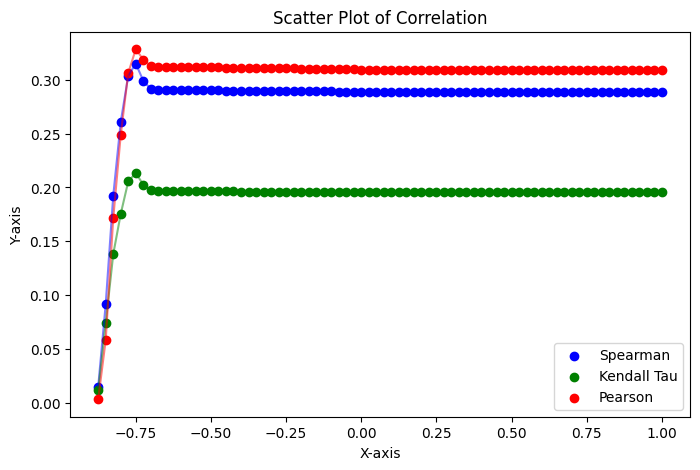

In [64]:
plot_scatter_theta(relu_corr_dict)

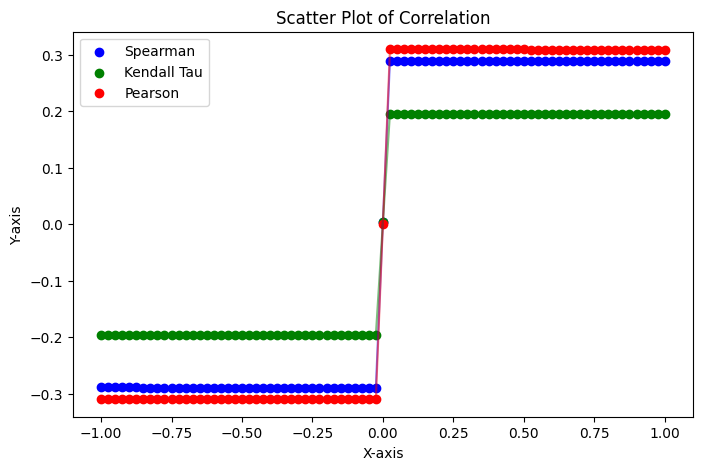

In [65]:
plot_scatter_theta(sig1_corr_dict)

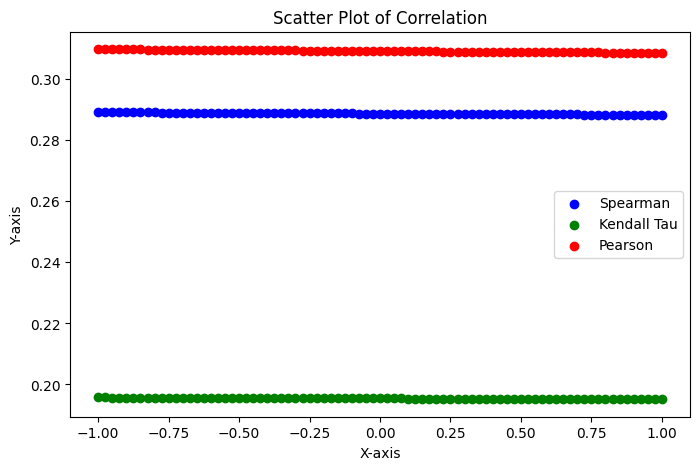

In [66]:
plot_scatter_theta(sig2_corr_dict)

### Compare Generated Index with EPU

In [32]:
def agg_daily(data, labels, name):
    data_agg = data[labels].sum(axis=1).to_frame()
    data_agg.index.names = ['date']
    data_agg = data_agg.groupby('date').mean()
    data_agg.columns = [name]
    return data_agg

In [33]:
cosine_sim_label = [f'cosine_sim_{i}' for i, label in enumerate(labels)]
relu_cosine_sim = np.maximum(0, cosine_sim[cosine_sim_label] - 0.75)
sigmoid_cosine_sim = 1 / (1 + np.exp(-(0.5 * cosine_sim[cosine_sim_label] + -1)))
arcsin_cosine_sim = np.arcsin(np.clip(cosine_sim[cosine_sim_label], -1, 1))
sq_relu_cosine_sim = np.maximum(cosine_sim[cosine_sim_label], 0) ** 2

In [34]:
cosine_sim_reg = agg_daily(cosine_sim, cosine_sim_label, 'cosine_sim_reg')
cosine_sim_relu = agg_daily(relu_cosine_sim, cosine_sim_label, 'cosine_sim_relu')
cosine_sim_sig = agg_daily(sigmoid_cosine_sim, cosine_sim_label, 'cosine_sim_sig')
cosine_sim_arc = agg_daily(arcsin_cosine_sim, cosine_sim_label, 'cosine_sim_arc')
cosine_sim_sq = agg_daily(sq_relu_cosine_sim, cosine_sim_label, 'cosine_sim_sq')

In [35]:
us_news = pd.read_parquet(get_format_data() / 'us_news.parquet.brotli')
cosine_sim_all = cosine_sim_reg.merge(us_news, left_index=True, right_index=True, how='left').dropna()
cosine_sim_all = cosine_sim_all.merge(cosine_sim_relu, left_index=True, right_index=True, how='left').dropna()
cosine_sim_all = cosine_sim_all.merge(cosine_sim_sig, left_index=True, right_index=True, how='left').dropna()
cosine_sim_all = cosine_sim_all.merge(cosine_sim_arc, left_index=True, right_index=True, how='left').dropna()
cosine_sim_all = cosine_sim_all.merge(cosine_sim_sq, left_index=True, right_index=True, how='left').dropna()

#### Plot

<Axes: xlabel='date'>

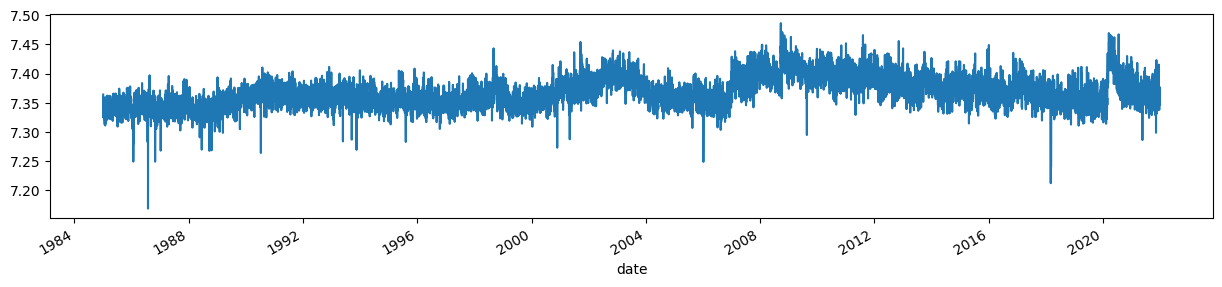

In [85]:
cosine_sim_all['cosine_sim_reg'].plot(figsize=(15, 3))

<Axes: xlabel='date'>

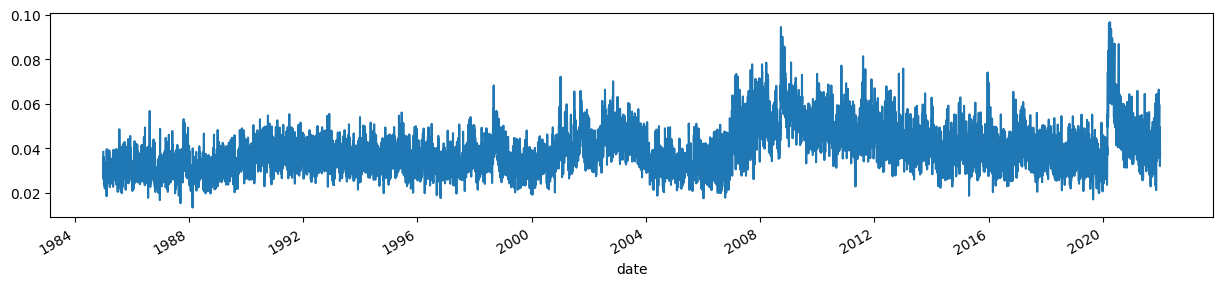

In [86]:
cosine_sim_all['cosine_sim_relu'].plot(figsize=(15, 3))

<Axes: xlabel='date'>

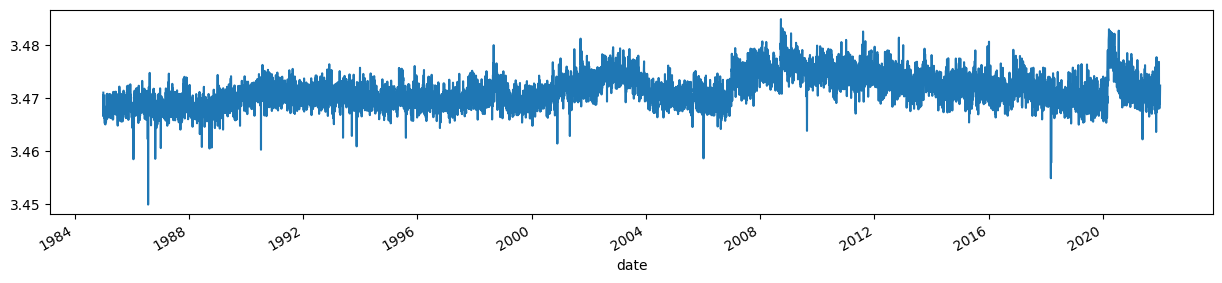

In [87]:
cosine_sim_all['cosine_sim_sig'].plot(figsize=(15, 3))

<Axes: xlabel='date'>

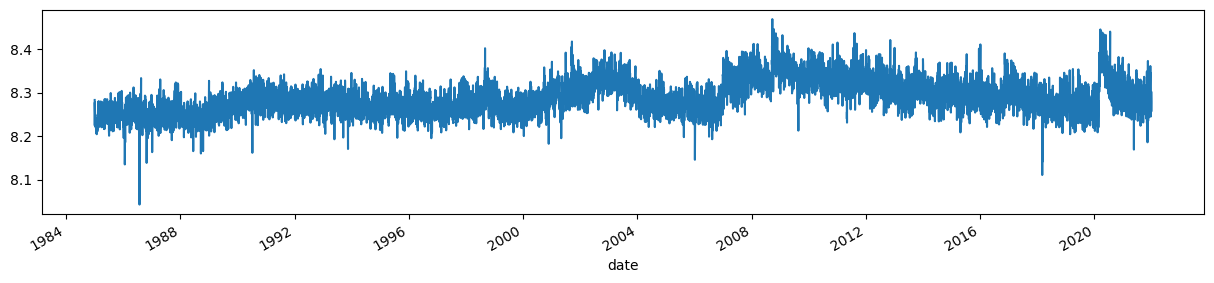

In [88]:
cosine_sim_all['cosine_sim_arc'].plot(figsize=(15, 3))

<Axes: xlabel='date'>

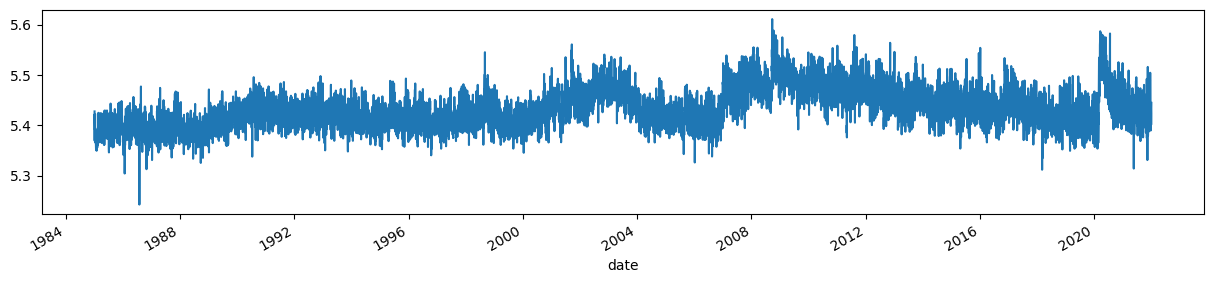

In [89]:
cosine_sim_all['cosine_sim_sq'].plot(figsize=(15, 3))

<Axes: xlabel='date'>

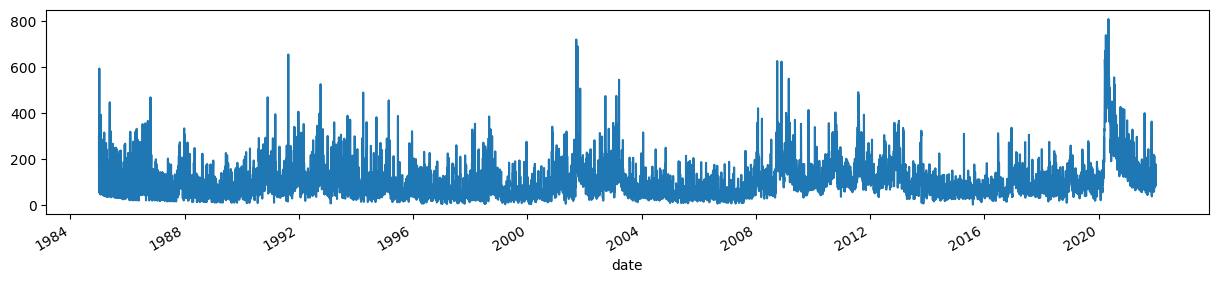

In [90]:
cosine_sim_all['daily_pol'].plot(figsize=(15, 3))

In [92]:
get_corr(cosine_sim_all, 'cosine_sim_relu', 'daily_pol')

{'p': 0.422602227814215, 's': 0.3426620325436919, 'k': 0.233888916170919}

### Monthly Aggregration

<Axes: xlabel='date'>

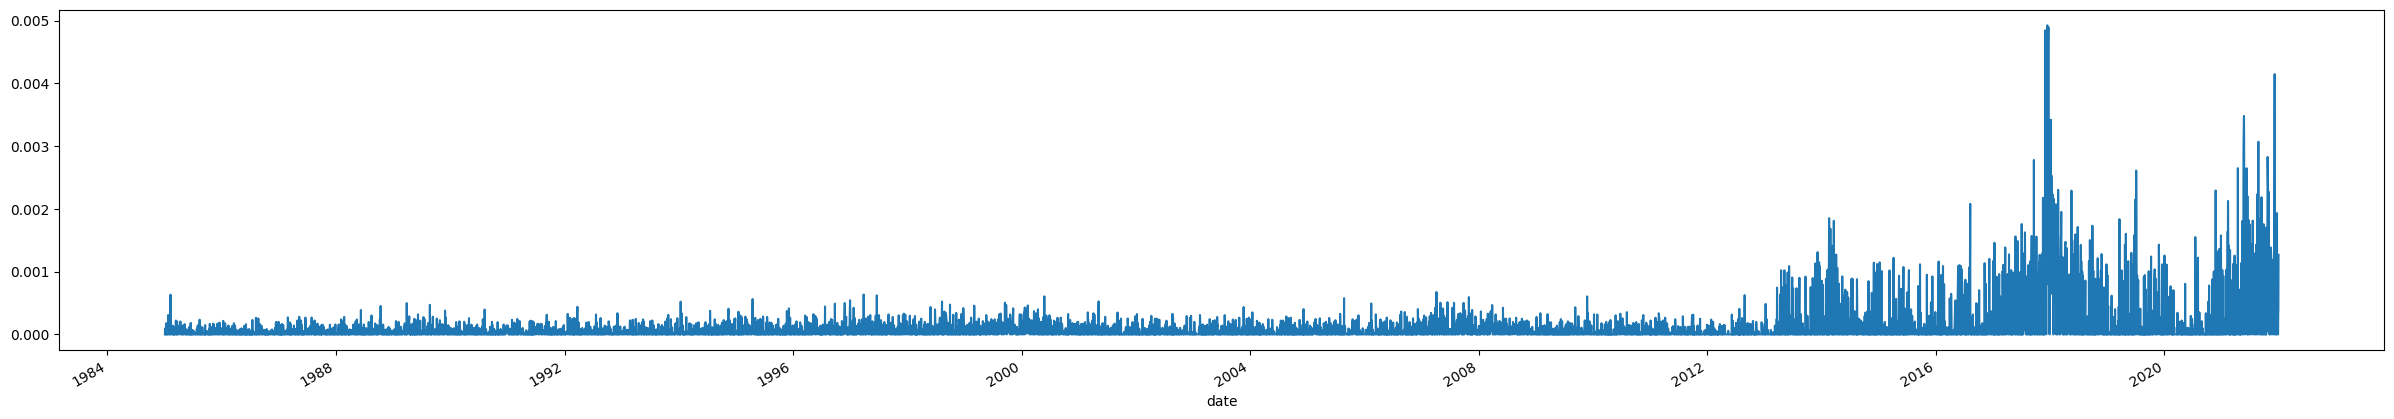

In [39]:
cosine_sim_all.cosine_sim_relu.plot(figsize=(30, 5))

In [37]:
month_cosine_sim_all = cosine_sim_all.resample('M').mean()x

<Axes: xlabel='date'>

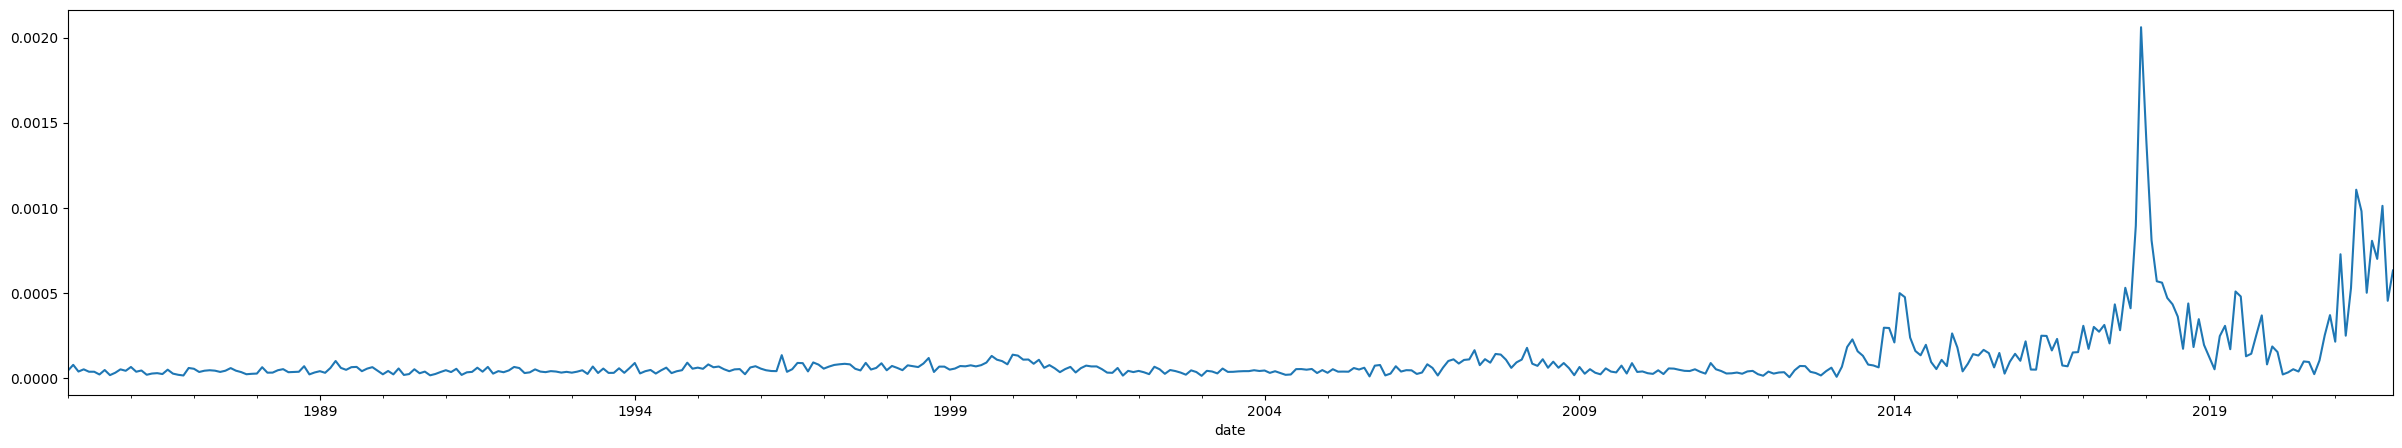

In [38]:
month_cosine_sim_all.cosine_sim_relu.plot(figsize=(30,5))

In [ ]:
month_cosine_sim_all.daily_pol.plot(figsize=(30,5))

In [144]:
get_corr(month_cosine_sim_all, 'cosine_sim_relu', 'daily_pol')

{'p': 0.6274101129234305, 's': 0.4988802432686064, 'k': 0.35076159681125824}

#### Inspect Article Count Per Day

array([[<Axes: title={'center': 'cosine_sim_0'}>]], dtype=object)

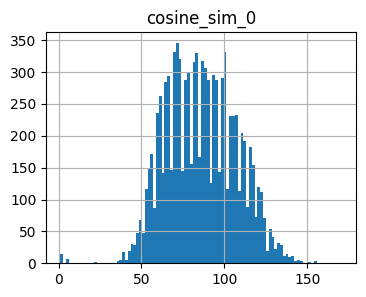

In [206]:
count = cosine_sim.groupby('date').agg('count')[['cosine_sim_0']]
count.hist(bins=100, figsize=(4, 3))